In [ ]:
!pip install --user tensorflow
!pip install shap
!pip install pyyaml h5py
!pip install scikit-learn
!pip install opencv-python matplotlib tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import precision_score, recall_score, f1_score,classification_report,confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
from google.colab import files

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from PIL import Image

img = Image.open("/content/drive/My Drive/forest_fire/train/fire/fire_0902.jpg")
print(img.size)


(250, 250)


In [ ]:
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory("/content/drive/My Drive/forest_fire/train/",
                                          batch_size = 32,
                                          class_mode = 'binary')

validation_dataset = train.flow_from_directory("/content/drive/My Drive/forest_fire/val/",
                                          batch_size = 32,
                                          class_mode = 'binary')

test_dataset = test.flow_from_directory("/content/drive/My Drive/forest_fire/test/",
                                          batch_size =32,
                                          class_mode = 'binary',
                                          shuffle= False)

Found 1330 images belonging to 2 classes.
Found 284 images belonging to 2 classes.
Found 286 images belonging to 2 classes.


In [ ]:
validation_dataset.class_indices

{'fire': 0, 'nofire': 1}

In [ ]:
modelA = keras.Sequential([
    keras.layers.Input(shape=(256, 256, 3)),
    keras.layers.Conv2D(32, (5, 5), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(128, (5, 5), activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
modelA.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    11,076,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,581,123 (44.18 MB)

 Trainable params: 11,581,121 (44.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
modelA.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',patience=5,verbose=1,restore_best_weights=True)

In [ ]:
r = modelA.fit(train_dataset, epochs = 50, validation_data=validation_dataset,callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 673s 16s/step - accuracy: 0.7185 - loss: 0.7167 - val_accuracy: 0.9366 - val_loss: 0.2003
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9516 - loss: 0.1523 - val_accuracy: 0.9331 - val_loss: 0.2317
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.9557 - loss: 0.1358 - val_accuracy: 0.9366 - val_loss: 0.1827
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9473 - loss: 0.1508 - val_accuracy: 0.9225 - val_loss: 0.2211
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.9516 - loss: 0.1660 - val_accuracy: 0.9366 - val_loss: 0.1842
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9581 - loss: 0.1356 - val_accuracy: 0.9437 - val_loss: 0.1729
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.9547 - loss: 0.0989 - val_accuracy: 0.9577 - val_loss: 0.1648
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9438 - loss: 0.1461 - val_accuracy: 0.

In [ ]:
predictions = modelA.predict(test_dataset)
predictions = np.round(predictions)

9/9 ━━━━━━━━━━━━━━━━━━━━ 163s 20s/step


In [ ]:
predictions

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [ ]:
print(len(predictions))

286


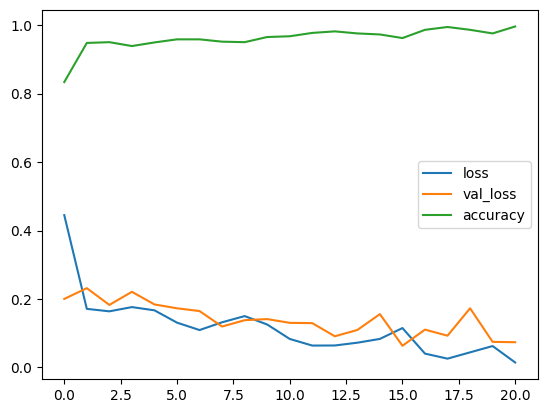

In [ ]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.plot(r.history['accuracy'], label='accuracy')
plt.legend()

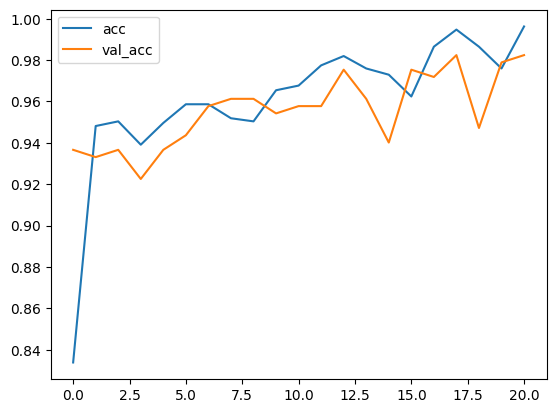

In [ ]:
#how much accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(256,256))
    plt.imshow(img1)
    Y = image.img_to_array(img1)
    X = np.expand_dims(Y,axis=0)
    val = modelA.predict(X)
    print(val)
    if val == 1:
        plt.xlabel("No Fire",fontsize=30)
    elif val == 0:
        plt.xlabel("Fire",fontsize=30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[0.]]


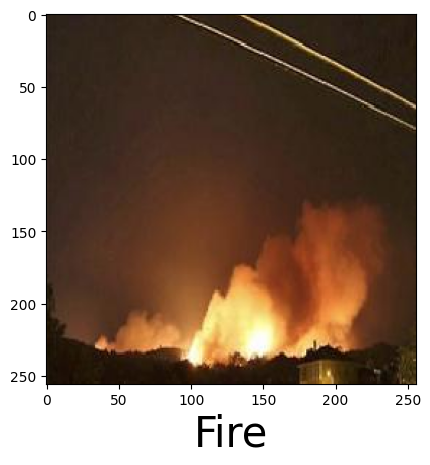

In [ ]:
predictImage("/content/drive/My Drive/forest_fire/Testing/fire/abc190.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.]]


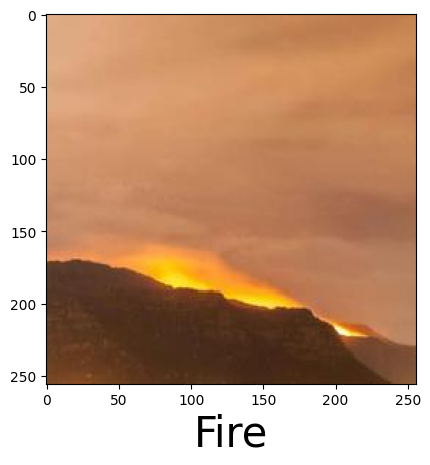

In [ ]:
predictImage("/content/drive/My Drive/forest_fire/Testing/fire/abc185.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[1.]]


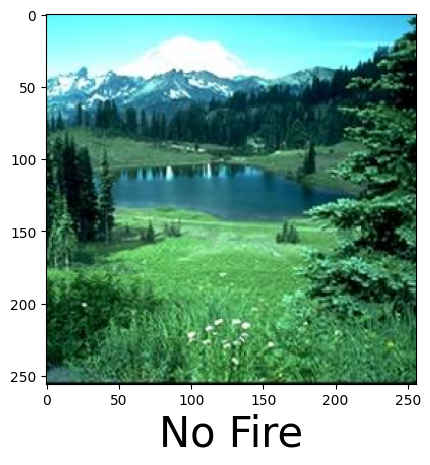

In [ ]:
predictImage("/content/drive/My Drive/forest_fire/Testing/nofire/abc377.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[1.]]


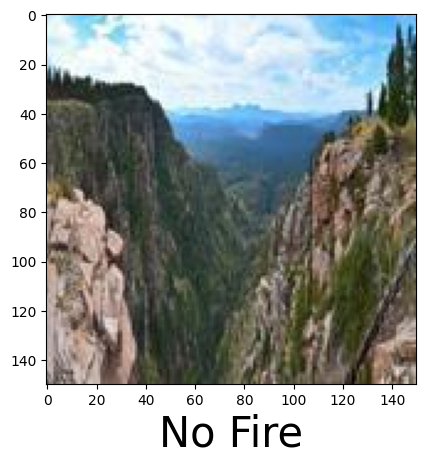

In [ ]:
predictImage("/content/drive/My Drive/wildfire/wildfire_dataset/test_resized/nofire/36644001004_f3e3a56edc_o.jpg")

In [ ]:
dataset_dir = "/content/drive/My Drive/forest_fire/Testing/"  # Update with your dataset path
image_path = "/content/drive/My Drive/forest_fire/Testing/fire/abc190.jpg"

In [ ]:
test_dataset.reset()
y_true = test_dataset.classes

print(f"Total test samples: {len(y_true)}")

print("Making predictions on the test dataset...")
predictions = modelA.predict(test_dataset)


y_pred = (predictions > 0.5).astype(int)
print("Predictions complete.")

precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')
cm = confusion_matrix(y_true, y_pred)


# Calculate FPR and FNR from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

fpr = fp / (fp + tn) * 100 if (fp + tn) != 0 else 0.0 # Convert to percentage
fnr = fn / (fn + tp) * 100 if (fn + tp) != 0 else 0.0 # Convert to percentage

# Convert other metrics to percentage as well for consistency with chart

precision_percent = precision * 100 # Not directly plotted in the original image, but good to have
recall_percent = recall * 100
f1_percent = f1 * 100

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print("\n--- Calculated Metrics for Customized CNN ---")

print(f"Precision: {precision_percent:.2f}%")
print(f"Recall:    {recall_percent:.2f}%")
print(f"F1-Score:  {f1_percent:.2f}%")
print(f"FPR:       {fpr:.2f}%")
print(f"FNR:       {fnr:.2f}%")

# Store your CNN's metrics in a dictionary
cnn_metrics = {
    'FPR': fpr,
    'FNR': fnr,
    'Precision': precision_percent,
    'Recall': recall_percent,
    'F1': f1_percent
}

Total test samples: 286
Making predictions on the test dataset...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
Predictions complete.

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       143
           1       0.96      0.97      0.97       143

    accuracy                           0.97       286
   macro avg       0.97      0.97      0.97       286
weighted avg       0.97      0.97      0.97       286


--- Calculated Metrics for Customized CNN ---
Precision: 95.86%
Recall:    97.20%
F1-Score:  96.53%
FPR:       4.20%
FNR:       2.80%


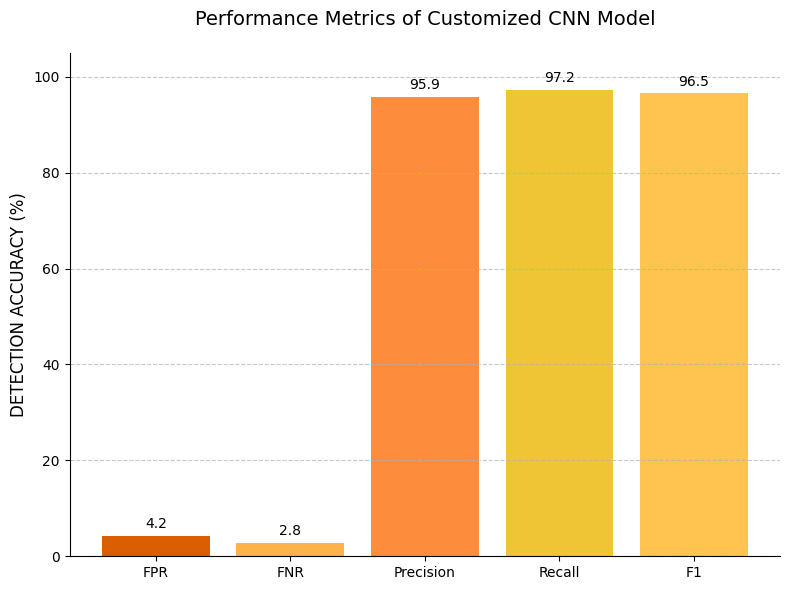

In [ ]:
metrics_names = list(cnn_metrics.keys())
metrics_values = list(cnn_metrics.values())

# --- 3. Generate the Single Bar Chart ---

fig, ax = plt.subplots(figsize=(8, 6)) # Adjust figure size

# Define custom colors for each bar if desired, or use a single color
colors = ['#d95f02', '#feb24c', '#fd8d3c', '#efc535', '#fec44f']

# Create the bars
bars = ax.bar(metrics_names, metrics_values, color=colors)

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, # +1 for a slight offset above the bar
            f'{yval:.1f}', ha='center', va='bottom', fontsize=10)


# Add some text for labels and title
ax.set_ylabel('DETECTION ACCURACY (%)', fontsize=12)
ax.set_ylim(0, 105) # Set y-axis limit to accommodate labels and values up to 100%

# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a title
plt.title('Performance Metrics of Customized CNN Model', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

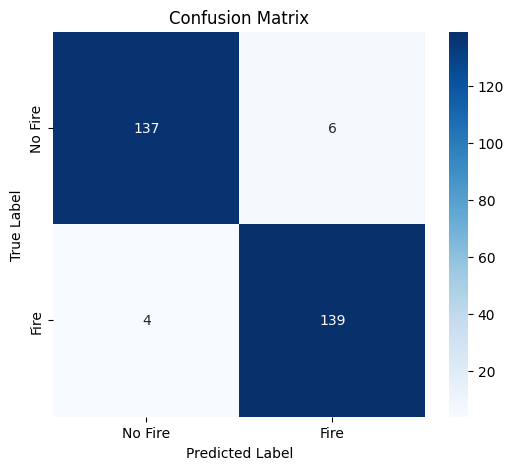

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plot as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.32s/it]               


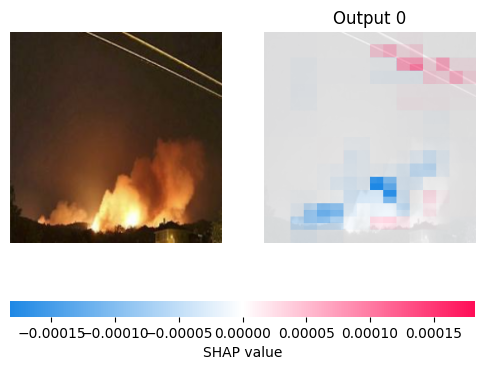

In [ ]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0
    return image.numpy()

def f(x):
    tmp = x.copy()
    return modelA(tmp)

# Define the SHAP masker for interpretability (blurring the background)
masker_blur = shap.maskers.Image("blur(256,256)", shape=(256, 256, 3))
image = preprocess_image(image_path)

# Create the SHAP explainer using the masker
explainer_blur = shap.Explainer(f, masker_blur)
shap_values = explainer_blur(image[np.newaxis, :, :, :], max_evals=5000)

# Visualize the SHAP values on the input image
shap.image_plot(shap_values)